In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import matplotlib.pyplot as plt

In [0]:
matplotlib.style.use('ggplot')

# Imports

In [0]:
import numpy as np
import pandas as pd
import requests

In [0]:
import os
import json
from copy import deepcopy

In [0]:
logging.basicConfig?

Object `logging.basicConfig` not found.


In [0]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.getLogger("requests").setLevel(logging.ERROR) # silencing requests logging 

# Logging for this notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO) # set this to whatever you'd like

# Introduction to the new FEC API

Making data accessible through the a modern API is a huge move forward for the Federal Elections Commission. With the help of a team of intrepid 18f developers, FEC is re-thinking both its website and its data offerings to better serve its mission of educating the public with real-time disclosure of campaign finance information. It's part of the larger OpenFEC project, and we think it's a very encouraging sign that this collaboration is going to improve access to a crucial information resource.

What follows is meant as both an introduction to what's available through this new resource and a critique of what's working well, and the changes Sunlight would like to see in future releases of the API.

# Doesn't the FEC already release data?

FEC is a model disclosure authority: it has made federal campaign finance data available through a searchable web portal, in bulk csv files, and, most impressively, a live feed of submitted disclosures. On Influence Explorer, we've made use of each of these sources in different ways - most recently turning that live feed into a searchable data resource at http://realtime.influenceexplorer.com.

Sunlight has consistently called on government sources to make all data available in bulk. It's difficult to know how a dataset might be used by a researcher, reporter, citizen or advocacy group, so it's important that government bodies release ALL of it in machine-readable bulk files to allow the fullest exploration of what's available and to give context to any given data point. The FEC has historically set an excellent example in making bulk data available. 

# Additional benefits from an API

We think pretty highly of what the FEC already offers, and encourage them to continue to make both bulk and streamed data available. Here at Sunlight, though, we tend to make the data we release available both in bulk and through APIs, because we think that APIs are the right kind of access for particular users and usecases. So what additional advantages are offered by an API?

## Selective data views

Not every user or developer can effectively make use of bulk data. It typically doesn't fit in an spreadsheet, so the point-and-click crowd can be at a loss right away. Even if you're technically skilled enough to load it into R or pandas, though, you may hit a barrier if the operations you want to carry out require that the data be loaded into memory. 

Furthermore, a bulk release may contain a lot of data that isn't relevant to a particular usecase or investigation. Let's say I want to look at contributions to House candidates who are Democrats in 2012. If I use the bulk release, I'm going to get a lot of data that's not interesting to me, including all of the contributions to non-candidate PACs, members of other parties, and contributions to presidential or senatorial candidates.

Pulling out exactly what you need usually requires loading everything into a database, setting up some indices, and running queries. True, there are some tools for working directly with CSV files, like the excellent [csvkit](https://csvkit.readthedocs.org/en/0.9.1/), but depending on your query, you again might run into memory issues. Good old \*nix standbys `grep`, `cut`, `sed` and `awk` can also get you pretty far, if you're willing to hone your shell scripts.

With an API, though, you can hand off this selection business to the data's source (in this case, FEC's data warehouse). As long as the API supports it, you can formulate your query and retrieve it with confidence. That's an important qualifier, though: The onus is on the API's design team to make sure that the views which are offered meet the needs of its likely users.

## Aggregate views

Another advantage to having an API is the ability to show up-to-date aggregations of the records in your database. This includes totals, rankings, and metadata that might change over time. 

Again, aggregation is something that anyone can perform on bulk data. That is, anyone with the technical know-how discussed in the last section, and the domain knowledge needed to properly compute aggregates. 

In the case of FEC data in particular, summing the dollar amounts of individual transactions can be deceptively difficult. Whether or not two amounts can be added together depends on the type of committee, the type of transaction, and sometimes also the type of contributor.

A certain level of legal and regulatory expertise is needed when calculating these sums, but might be out of scope for a developer that wants to add or explore some summary statistics from campaign finance, but for whom campaign finance is not the main focus of investigation. Maybe the focus is on projected vote share, and the campaign finance information is going to be added for context. In cases like that, it's useful to source the aggregate totals published by the FEC itself, and an API is a great way to deliver that data.

## Live data

In addition to being more focused and infused with expertise, data views made available through an API can be tied to live data. In the case of the FEC's new API, the data is updated daily. This partially avoids the need for a developer to repeatedly update their database with successive bulk data releases.

In fact, for some usecases, an API might obviate the need for a database altogether.  Imagine again the case of a website that shows some other, non-campaign-finance data, such as legislative activity or election results. If campaign finance data could be a helpful addition to that kind of app, the developer can avoid having to build a big addition onto their database by making client-side calls with javascript. The site, which may be backed by a large database, can deliver data in a web app, and then obtain FEC's aggregate totals or summary facts on-the-fly, allowing them to show up if and when the site's designers choose.

# Brief tour

Here's a very quick tour of what you can expect from the OpenFEC API.

## What's Available

The [official documentation](https://api.open.fec.gov/developers) for the API is the best source for getting to know what it has to offer, but here are some of the things you can look forward to interacting with:

  1. **Search By Name** - Nearly every question that can be answered with FEC data requires knowing the unique identifiers that FEC has assigned to the entities involved. The search endpoints make acquiring these identifiers straightforward.
  2. **Candidate and Committee Details** - Armed with the right identifiers, one can access a lot of important information about any candidate or committee, including location information, FEC designations, and the entity's history.
  3. **Financial Reports** - For each committee, you can obtain the top-line numbers describing contributions, reciepts, expenditures and loans. These are sourced from the committee's periodically-filed financial reports. These come complete with links to the PDF (shudder) of the original filing.
  4. **Per-Cycle Committee Summaries** - In addition to the individual reports' numbers, the API also makes available top-line numbers aggregated on a per-cycle basis.
  
In other words, FEC's first API is off to a very promising start. Armed with just this data, there are already a lot of opportunities to keep up with campaign finance during the 2016 election. 

## Our Wish List

While we were excited to see the progress made so far, there's a few things we'd really like to see added to the API.

  1. **Endpoints for Itemized Data** - having endpoints dedicated to the itemized transactions that show up on Schedule A (Receipts), Schedule B (Disbursements), and Schedule E (expenditures) should be the first priority for new additions the API. There is a tremendous amount of useful information that is contained in these line items. Without an endpoint for itemized transactions, the bulk data and live feeds still offer much that the API does not. *NOTE: Thanks to the OpenFEC team's [in-the-open development](https://github.com/18F/openFEC) on Github, there's [evidence](https://github.com/18F/openFEC/blob/2022c0a965f878e0c62521d321104a52c9e500e5/webservices/rest.py#L178-L194) that this is on the way!*
  2. **Per-Contributor/Per-Recipient Aggregates** - Campaign finance data is essentially the description of the relationships between contributors and their recipients. Endpoints are needed that list (a) the per-contributor, per-cycle aggregate totals of reciepts and (b) the per-recipient, per-cycle aggregate totals of disbursements. It's unfortunate that, given the state of disclosure, these can only include PAC-to-candidate and PAC-to-PAC transactions, but they're very useful nonetheless.
  3. **Independent Expenditure Aggregates** - In a world strongly influenced by the behavior of Independent-Expenditure Only PACs (aka Super PACs), it's very important to be able to ask two questions: (a) for a given Super PAC, who have they spent the most money targeting negatively/positively? and (b) for a given candidate, who has spent the most targeting them negatively/positively? This data is available from FEC, but isn't an endpoint, yet.

# Sunlight from the inside out

A quick note: the group of developers working on OpenFEC includes two former Sunlight labs members. We couldn't be prouder of the work they've been doing during their time "on the inside." It's unsurprising, though, that they've been effective at 18f and more specifically on the OpenFEC project. Lindsay Young developed our portal for accessing a live feed Foreign Agent Registration Act, and Alison Rowland was my predecessor as project lead on Influence Explorer. We miss them both, but we're very grateful for the hard work they and their team are putting into improving public access to campaign finance disclosure at the federal level.

# Exploring the API

The base URL for the API is

In [0]:
BASE_URL = 'http://api.open.fec.gov/v1'

You'll also need a data.gov API key, which you can obtain [here](https://api.data.gov/signup/). I save my API keys in a plain text file in my home directory, so that they're always handy and so that I can use them without revealing them in notebooks like this one.

In [0]:
API_KEY = open(os.path.expanduser('~/.api-keys/data.gov'),'r').read().strip()

Conceptually, there are 2 main areas of focus for the API: Candidates and Committees. When looking at contributions, however, remember that recipients are always committees. Candidates do not recieve contributions directly: their committees do. Here are the relevant branches:

  - `/candidate`: individual candidate information
  - `/committee`: individual committee information

## Documentation

We're going to cover a fair bit of ground in this introduction, but for more details on what's possible, check the [official OpenFEC API documentation](https://api.open.fec.gov/developers).

## Helpful Utils

Some methods and global vars to help us stay succinct below.

In [0]:
def all_results(endpoint, params):
    _params = deepcopy(params)
    _params.update({'api_key': API_KEY})
    _url = BASE_URL+endpoint
    logging.info('querying endpoint: {}'.format(_url))
    
    initial_resp = requests.get(_url, params=_params)
    
    logging.debug('full url eg: {}'.format(initial_resp.url))
            
    initial_data = initial_resp.json()
    
    num_pages = initial_data['pagination']['pages']
    num_records = initial_data['pagination']['count']
    logging.info('{p} pages to be retrieved, with {n} records'.format(
            p=num_pages, n=num_records))
    
    current_page = initial_data['pagination']['page']
    logging.debug('page {} retrieved'.format(current_page))
    
    for record in initial_data['results']:
        yield record
    
    while current_page < num_pages:
        current_page += 1
        _params.update({'page': current_page})
        _data = requests.get(_url, params=_params).json()
        logging.debug('page {} retrieved'.format(current_page))
        for record in _data['results']:
            yield record
            
    logging.info('all pages retrieved')
    
def count_results(endpoint, params):
    _params = deepcopy(params)
    _params.update({'api_key': API_KEY})
    _url = BASE_URL+endpoint
    
    _data = requests.get(_url, params=_params).json()
    
    return _data['pagination']['count']

# FEC Identifiers: The Keys to All Data

To get data associated with a candidate or a committee, you need to know the identifier that FEC has assigned to that entity. In case you don't have those memorized, though, there are two ways to obtain the IDs that you need: you can search for them, or obtain optionally filtered lists.

## Searching

Data on candidate and committee entities can be found using the search endpoints for each type:

- `/candidates/search`
- `/committees/search`

Let's try looking for a candidate.

In [0]:
q_obama = {
    'q': 'obama',
}

[r for r in all_results('/candidates/search', q_obama)]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidates/search
INFO:root:1 pages to be retrieved, with 3 records
INFO:root:all pages retrieved


[{u'active_through': 2000,
  u'candidate_id': u'H0IL01087',
  u'candidate_status': u'P',
  u'candidate_status_full': u'Statutory candidate in a prior cycle',
  u'cycles': [2000],
  u'district': u'01',
  u'election_years': [2000],
  u'incumbent_challenge': None,
  u'incumbent_challenge_full': u'Unknown',
  u'name': u'OBAMA, BARACK H',
  u'office': u'H',
  u'office_full': u'House',
  u'party': u'DEM',
  u'party_full': u'Democratic Party',
  u'principal_committees': [{u'candidate_ids': [u'H0IL01087'],
    u'committee_id': u'C00347583',
    u'committee_type': u'H',
    u'committee_type_full': u'House',
    u'cycles': [2000, 2002, 2004],
    u'designation': u'P',
    u'designation_full': u'Principal campaign committee',
    u'expire_date': None,
    u'first_file_date': None,
    u'last_file_date': u'2004-10-13T00:00:00+00:00',
    u'name': u'OBAMA FOR CONGRESS 2000',
    u'organization_type': None,
    u'organization_type_full': None,
    u'party': u'DEM',
    u'party_full': u'Democratic Pa

Wait, there are THREE Barack Obama's? Well, not quite. the FEC assigns an identifier each time someone runs for a particular office. Obama has an FEC ID that starts with `P` because he ran for president, but also picked up two more when he ran for seats in the House (`H`) and Senate (`S`).

The FEC data doesn't do any formal reconciliation of these records, so it's something to look out for when you're looking at someone's history. For instance, if we were to use `P80003338` to look up Obama's history using the `/candidate/{candidate_id}/history` endpoint, we might expect to see those other identifiers somewhere. Unfortunately, that's not the case:

In [0]:
[r for r in all_results('/candidate/P80003338/history', {})]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338/history
INFO:root:1 pages to be retrieved, with 3 records
INFO:root:all pages retrieved


[{u'address_city': u'CHICAGO',
  u'address_state': u'IL',
  u'address_street_1': u'PO BOX 8102',
  u'address_street_2': None,
  u'address_zip': u'60680',
  u'candidate_id': u'P80003338',
  u'candidate_inactive': None,
  u'candidate_status': u'C',
  u'candidate_status_full': u'Statutory candidate',
  u'cycles': [2008, 2010, 2012],
  u'district': None,
  u'election_years': [2008, 2012],
  u'expire_date': None,
  u'form_type': u'F2Z',
  u'incumbent_challenge': u'I',
  u'incumbent_challenge_full': u'Incumbent',
  u'load_date': u'2015-05-11T12:15:43+00:00',
  u'name': u'OBAMA, BARACK',
  u'office': u'P',
  u'office_full': u'President',
  u'party': u'DEM',
  u'party_full': u'Democratic Party',
  u'state': u'US',
  u'two_year_period': 2012},
 {u'address_city': u'CHICAGO',
  u'address_state': u'IL',
  u'address_street_1': u'PO BOX 8102',
  u'address_street_2': None,
  u'address_zip': u'60680',
  u'candidate_id': u'P80003338',
  u'candidate_inactive': None,
  u'candidate_status': u'C',
  u'cand

## Listing

We can also obtain a list of many candidates, applying optional filtering constraints if we don't want the ENTIRE list. This can be done at the `/candidates` endpoint. The metadata in the records returned can help when building a local reference resource or lookup table.

In [0]:
q_all_2012_candidates = {
    "cycle": 2012,
}

This query is going to return a LOT of candidates:

In [0]:
count_results('/candidates', q_all_2012_candidates)

3024

You can limit the list by specifying the `candidate_status`. Most of the time, what we care about are candidates with `candidate_status=C`, which means they are a declared candidate who has raised at least $5,000 in that cycle. 

In [0]:
q_all_2012_present_candidates = {
    "cycle": 2012,
    "candidate_status": "C"
}

In [0]:
count_results('/candidates', q_all_2012_present_candidates)

1885

It's true that we're looking at all federal races in 2012, but that's still a pretty big number. Let's pull that data down and see how it looks.

In [0]:
candidates_2012 = [c for c in all_results('/candidates', q_all_2012_present_candidates)]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidates
INFO:root:95 pages to be retrieved, with 1885 records
INFO:root:all pages retrieved


In [0]:
[c for c in candidates_2012 if 'OBAMA' in c['name']]

[{u'active_through': 2012,
  u'candidate_id': u'P80003338',
  u'candidate_status': u'C',
  u'candidate_status_full': u'Statutory candidate',
  u'cycles': [2008, 2010, 2012],
  u'district': None,
  u'election_years': [2008, 2012],
  u'incumbent_challenge': u'I',
  u'incumbent_challenge_full': u'Incumbent',
  u'name': u'OBAMA, BARACK',
  u'office': u'P',
  u'office_full': u'President',
  u'party': u'DEM',
  u'party_full': u'Democratic Party',
  u'state': u'US'}]

In [0]:
candidates_2012_df = pd.DataFrame(candidates_2012)

In [0]:
candidates_2012_df.head()

,active_through,candidate_id,candidate_status,candidate_status_full,cycles,district,election_years,incumbent_challenge,incumbent_challenge_full,name,office,office_full,party,party_full,state
0,2012,S2UT00229,C,Statutory candidate,[2012],None,[2012],C,Challenger,"AALDERS, TIMOTHY NOEL",S,Senate,REP,Republican Party,UT
1,2012,H2CA01110,C,Statutory candidate,[2012],01,[2012],C,Challenger,"AANESTAD, SAMUEL",H,House,REP,Republican Party,CA
2,2012,H2AZ02279,C,Statutory candidate,[2012],02,[2012],C,Challenger,"ABOUD, PAULA ANN",H,House,DEM,Democratic Party,AZ
3,2012,H2CA25176,C,Statutory candidate,[2012],25,[2012],C,Challenger,"ACOSTA, DANTE",H,House,REP,Republican Party,CA
4,2014,H8NC03043,C,Statutory candidate,"[2008, 2010, 2012, 2014]",03,"[2008, 2014]",C,Challenger,"ADAME, MARSHALL RICHARD",H,House,DEM,Democratic Party,NC


Since we had some high counts, let's look at how they break down (note the log scale on the x axis).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a3aa85bd0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4a39cdcf50>], dtype=object)

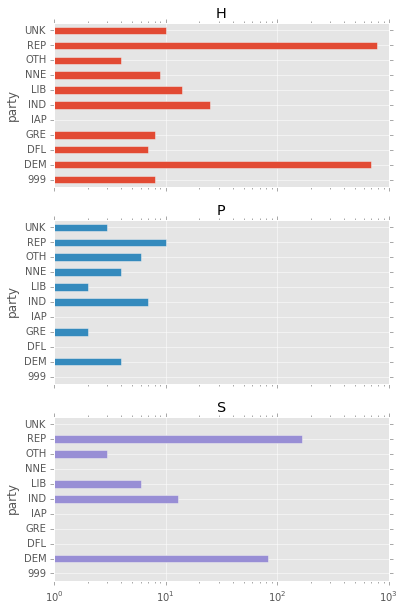

In [0]:
candidates_2012_df.pivot_table(
    index='party',
    columns='office',
    values='candidate_id',
    aggfunc=np.size
).plot(
    kind='barh',
    subplots=True,
    figsize=(6,10),
    logx=True,
    legend=False,
    xticks=[1, 10, 100, 1000]
)

So while these numbers seem a higher than you might expect, they're in the right proportion: Democrats and Republicans are the most common parties (at least among the congressional candidates), there are far more candidates for house than there are for senate, and candidates for president make up the smallest population.  Still, why are there so many more candidates than we remember seeing in 2012?

The answer is that, while mainstream election coverage typically focuses on candidates that are likely to be competitive and/or associated with a major national party, the FEC is responsible for reporting the campaign finance records for everyone who registers with the FEC as a candidate. 

## Focusing on select entities

Let's look at the names of those candidates who raised more than $5000 in a bid for the oval office:

In [0]:
q_all_2012_present_prez_candidates = {
    "cycle": 2012,
    "candidate_status": "C",
    "office": "P",
}

In [0]:
count_results('/candidates', q_all_2012_present_prez_candidates)

39

In [0]:
prez_candidates_2012 = [c for c in all_results('/candidates',
                                               q_all_2012_present_prez_candidates)]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidates
INFO:root:2 pages to be retrieved, with 39 records
INFO:root:all pages retrieved


In [0]:
prez_candidates_2012_df = pd.DataFrame(prez_candidates_2012)

In [0]:
prez_candidates_2012_df[['name','party','candidate_id']].sort('party')

,name,party,candidate_id
12,"GOODE, VIRGIL H JR",999,P20004685
6,"CARTER, WILLIE FELIX",DEM,P80000268
14,"HERMAN, RAPHAEL",DEM,P20002184
23,"OBAMA, BARACK",DEM,P80003338
27,"RICHARDSON, DARCY G",DEM,P20001376
22,"MESPLAY, KENT P",GRE,P40003279
33,"STEIN, JILL",GRE,P20003984
11,"FARNSWORTH, VERL",IND,P20002853
21,"MCCALL, JAMES HATTON",IND,P80003361
25,"RAKOWITZ, ARTHUR FABIAN",IND,P20003448


Yep, that's quite a large field. Keep this in mind when pulling your data: you'll probably want to make editorial choices about which candidates you'd like to focus on. That could be as easy as filtering your results after obtaining them from the API:

In [0]:
candidates_to_focus_on = ['PAUL, RON',
                          'OBAMA, BARACK',
                          'ROMNEY / PAUL D. RYAN, MITT']
                          
candidate_filter = prez_candidates_2012_df.name.str.match(
    '|'.join(candidates_to_focus_on), case=False)

In [0]:
prez_candidates_2012_df[candidate_filter].T

,23,24,30
active_through,2012,2012,2012
candidate_id,P80003338,P80000748,P80003353
candidate_status,C,C,C
candidate_status_full,Statutory candidate,Statutory candidate,Statutory candidate
cycles,"[2008, 2010, 2012]","[1988, 1990, 1992, 1994, 1996, 1998, 2000, 200...","[2008, 2010, 2012]"
district,None,None,None
election_years,"[2008, 2012]","[1988, 1990, 2008, 2012]","[2008, 2012]"
incumbent_challenge,I,C,C
incumbent_challenge_full,Incumbent,Challenger,Challenger
name,"OBAMA, BARACK","PAUL, RON","ROMNEY / PAUL D. RYAN, MITT"


If you plan to regularly update your data, though, you might want to store the identifiers for the entities you're interested in and use those for future API calls.

In [0]:
q_my_2012_prez_candidates = {
    "cycle": 2012,
    "candidate_status": "C",
    "office": "P",
    "candidate_id": ['P80003338', 'P80000748', 'P80003353', 'P20002523', 'P20003984']
}

In [0]:
my_2012_prez_candidates = [c for c in all_results('/candidates', q_my_2012_prez_candidates)]
my_2012_prez_candidates_df = pd.DataFrame(my_2012_prez_candidates)
my_2012_prez_candidates_df.T

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidates
INFO:root:1 pages to be retrieved, with 5 records
INFO:root:all pages retrieved


,0,1,2,3,4
active_through,2012,2012,2012,2012,2012
candidate_id,P80003338,P80000748,P20002523,P80003353,P20003984
candidate_status,C,C,C,C,C
candidate_status_full,Statutory candidate,Statutory candidate,Statutory candidate,Statutory candidate,Statutory candidate
cycles,"[2008, 2010, 2012]","[1988, 1990, 1992, 1994, 1996, 1998, 2000, 200...",[2012],"[2008, 2010, 2012]",[2012]
district,None,None,None,None,None
election_years,"[2008, 2012]","[1988, 1990, 2008, 2012]",[2012],"[2008, 2012]",[2012]
incumbent_challenge,I,C,C,C,C
incumbent_challenge_full,Incumbent,Challenger,Challenger,Challenger,Challenger
name,"OBAMA, BARACK","PAUL, RON","ROEMER, CHARLES E. ''BUDDY'' III","ROMNEY / PAUL D. RYAN, MITT","STEIN, JILL"


# Using Identifiers to Obtain Candidate Data

If we want to know more about a given candidate, we have some options. Using the `candidate_id` field, we can make requests to the `/candidate` endpoint to get a detailed profile. Note that the identifier needs to be included as part of the **path**, not as a GET argument.

In [0]:
[r for r in all_results('/candidate/P80003338',{})]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved


[{u'active_through': 2012,
  u'address_city': u'CHICAGO',
  u'address_state': u'IL',
  u'address_street_1': u'PO BOX 8102',
  u'address_street_2': None,
  u'address_zip': u'60680',
  u'candidate_id': u'P80003338',
  u'candidate_inactive': None,
  u'candidate_status': u'C',
  u'candidate_status_full': u'Statutory candidate',
  u'cycles': [2008, 2010, 2012],
  u'district': None,
  u'election_years': [2008, 2012],
  u'expire_date': None,
  u'form_type': u'F2Z',
  u'incumbent_challenge': u'I',
  u'incumbent_challenge_full': u'Incumbent',
  u'load_date': u'2015-05-11T12:15:43+00:00',
  u'name': u'OBAMA, BARACK',
  u'office': u'P',
  u'office_full': u'President',
  u'party': u'DEM',
  u'party_full': u'Democratic Party',
  u'state': u'US'}]

## Looking Up Candidate Committees

Let's continue to look at those presidential candidates. How much did each one raise in 2012? We can start to answer that question by looking at their committees, using the following endpoint:

    /candidate/{candidate_id}/committees/history/{cycle}

In [0]:
count_results('/candidate/P80003338/committees',{'cycle':2012})

21

Hm, that's odd, he probably didn't have 21 committees.

In [0]:
[r['name'] for r in 
 all_results('/candidate/P80003338/committees',{'cycle':2012})]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338/committees
INFO:root:2 pages to be retrieved, with 21 records
INFO:root:all pages retrieved


[u'ALASKAN WOMEN FOR OBAMA',
 u'CALIFORNIANS FOR CHANGE',
 u'COALITION FOR CHANGE',
 u'DC LGBT FOR SECOND TERM',
 u'OBAMA - COMMITTEE TO ELECT',
 u'OBAMA FOR AMERICA',
 u'OBAMA VICTORY FUND',
 u'OBAMA VICTORY FUND 2012',
 u'PA MOVING FORWARD',
 u'REALISTIC AND TRUTHFUL',
 u'SUPPORT THE PREZ',
 u'SWING STATE VICTORY FUND',
 u'WNC FOR CHANGE',
 u'YES WE CAN NEBRASKA']

What's happening here is that the API is returning all committees that claim to be associated with Obama. Some do so because they intended to raise money specifically for him, and others are "Single Candidate Independent Expenditure" groups. Most, though, are of designation "Unauthorized".

In [0]:
[(r['designation_full'],r['committee_type_full']) for r in all_results('/candidate/P80003338/committees',{'cycle':2012})]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338/committees
INFO:root:2 pages to be retrieved, with 21 records
INFO:root:all pages retrieved


[(u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Unauthorized', u'PAC - Nonqualified'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Principal campaign committee', u'Presidential'),
 (u'Joint fundraising committee', u'PAC - Nonqualified'),
 (u'Joint fundraising committee', u'PAC - Nonqualified'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Unauthorized', u'Single Candidate Independent Expenditure'),
 (u'Joint fundraising committee', u'PAC - Nonqualified'),
 (u'Unauthorized', u'PAC - Nonqualified'),
 (u'Unauthorized', u'PAC - Nonqualified')]

For now, let's focus on Obama's principal campaign committee. We can limit the results using the `designation` field and the `committee_type` field:

In [0]:
[r for r in 
 all_results('/candidate/P80003338/committees',
             {'cycle':2012, 'designation': 'P', 'committee_type': 'P'})]

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338/committees
INFO:root:1 pages to be retrieved, with 2 records
INFO:root:all pages retrieved


[{u'candidate_ids': [u'P80003338'],
  u'city': u'CHICAGO',
  u'committee_id': u'C00431445',
  u'committee_type': u'P',
  u'committee_type_full': u'Presidential',
  u'custodian_city': None,
  u'custodian_name_1': None,
  u'custodian_name_2': None,
  u'custodian_name_full': None,
  u'custodian_name_middle': None,
  u'custodian_name_prefix': None,
  u'custodian_name_suffix': None,
  u'custodian_name_title': None,
  u'custodian_phone': None,
  u'custodian_state': None,
  u'custodian_street_1': None,
  u'custodian_street_2': None,
  u'custodian_zip': None,
  u'cycles': [2008, 2010, 2012, 2014, 2016],
  u'designation': u'P',
  u'designation_full': u'Principal campaign committee',
  u'email': u'OFAFEC@BARACKOBAMA.COM',
  u'expire_date': u'2015-05-11T00:00:00+00:00',
  u'fax': None,
  u'filing_frequency': u'Q',
  u'first_file_date': u'2007-01-16T00:00:00+00:00',
  u'form_type': u'F1Z',
  u'last_file_date': u'2013-01-31T00:00:00+00:00',
  u'leadership_pac': None,
  u'load_date': u'2015-05-11T12

We'll have to combine multiple API calls to get everyone we care about.

In [0]:
my_2012_prez_committees = []

for i, row in my_2012_prez_candidates_df.iterrows():
    endpoint = '/candidate/{c}/committees'.format(c=row.candidate_id)
    for res in all_results(endpoint, {'cycle':2012,
                                      'designation': 'P',
                                      'committee_type': 'P'}):
        res['candidate_id'] = row.candidate_id
        my_2012_prez_committees.append(res)

INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003338/committees
INFO:root:1 pages to be retrieved, with 2 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80000748/committees
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P20002523/committees
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P80003353/committees
INFO:root:1 pages to be retrieved, with 2 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/candidate/P20003984/committees
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved


In [0]:
my_2012_prez_committees_df = pd.DataFrame(my_2012_prez_committees)

In [0]:
my_2012_prez_committees_df[['name','committee_id','candidate_id']]

,name,committee_id,candidate_id
0,OBAMA FOR AMERICA,C00431445,P80003338
1,RON PAUL 2012 PRESIDENTIAL CAMPAIGN COMMITTEE ...,C00495820,P80000748
2,"BUDDY ROEMER FOR PRESIDENT, INC.",C00493692,P20002523
3,"ROMNEY FOR PRESIDENT, INC.",C00431171,P80003353
4,JILL STEIN FOR PRESIDENT,C00505800,P20003984


## Obtaining Committee Summaries

Now that we have identifiers for the primary campaign committees  associated with each candidate, we can obtain some interesting summary information about them. There are two different endpoints for getting financial information:

 - `/committee/{committee_id}/totals` (straightforward cyclewide totals)
 - `/committee/{committee_id}/reports` (actual reports submitted. advanced content!)
    
Let's look at the more straightforward totals endpoint:

In [0]:
my_2012_prez_committee_totals = []

for i, row in my_2012_prez_committees_df.iterrows():
    endpoint = '/committee/{c}/totals'.format(c=row.committee_id)
    for res in all_results(endpoint, {'cycle':2012}):
        my_2012_prez_committee_totals.append(res)

INFO:root:querying endpoint: http://api.open.fec.gov/v1/committee/C00431445/totals
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/committee/C00495820/totals
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/committee/C00493692/totals
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/committee/C00431171/totals
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved
INFO:root:querying endpoint: http://api.open.fec.gov/v1/committee/C00505800/totals
INFO:root:1 pages to be retrieved, with 1 records
INFO:root:all pages retrieved


In [0]:
my_2012_prez_committee_totals_df = pd.DataFrame(my_2012_prez_committee_totals)

In [0]:
my_2012_prez_committee_totals_df[['committee_id','contributions','disbursements','receipts',]]

,committee_id,contributions,disbursements,receipts
0,C00431445,549594250,737507855,738503770
1,C00495820,39928730,39968390,41060317
2,C00493692,400036,739453,780900
3,C00431171,304959168,483073478,483452331
4,C00505800,819034,1122027,1263540


Merging these facts together with the metadata that we've already collected, we can start to produce some good comparisons:

In [0]:
my_2012_prez_candidates_df.columns

Index([u'active_through', u'candidate_id', u'candidate_status', u'candidate_status_full', u'cycles', u'district', u'election_years', u'incumbent_challenge', u'incumbent_challenge_full', u'name', u'office', u'office_full', u'party', u'party_full', u'state'], dtype='object')

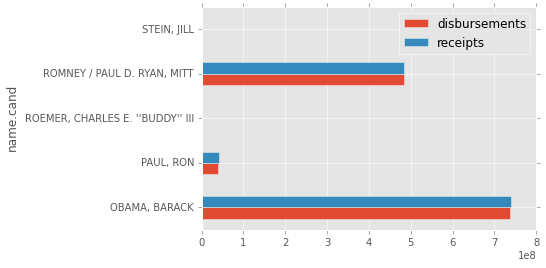

In [0]:
comparison = my_2012_prez_committees_df.set_index('committee_id').join(
                my_2012_prez_committee_totals_df.set_index('committee_id'), rsuffix='.cmte')

comparison = comparison.set_index('candidate_id').join(
                my_2012_prez_candidates_df.set_index('candidate_id'), rsuffix='.cand')

comparison.set_index('name.cand')[
    ['disbursements','receipts',]].plot(kind='barh')

In [0]:
[c for c in comparison.columns]

[u'candidate_ids',
 u'city',
 u'committee_type',
 u'committee_type_full',
 u'custodian_city',
 u'custodian_name_1',
 u'custodian_name_2',
 u'custodian_name_full',
 u'custodian_name_middle',
 u'custodian_name_prefix',
 u'custodian_name_suffix',
 u'custodian_name_title',
 u'custodian_phone',
 u'custodian_state',
 u'custodian_street_1',
 u'custodian_street_2',
 u'custodian_zip',
 u'cycles',
 u'designation',
 u'designation_full',
 u'email',
 u'expire_date',
 u'fax',
 u'filing_frequency',
 u'first_file_date',
 u'form_type',
 u'last_file_date',
 u'leadership_pac',
 u'load_date',
 u'lobbyist_registrant_pac',
 u'name',
 u'organization_type',
 u'organization_type_full',
 u'party',
 u'party_full',
 u'party_type',
 u'party_type_full',
 u'qualifying_date',
 u'state',
 u'state_full',
 u'street_1',
 u'street_2',
 u'treasurer_city',
 u'treasurer_name',
 u'treasurer_name_1',
 u'treasurer_name_2',
 u'treasurer_name_middle',
 u'treasurer_name_prefix',
 u'treasurer_name_suffix',
 u'treasurer_name_title',

In [0]:
comparison.set_index('name.cand')[
    ['individual_itemized_contributions',
     'individual_unitemized_contributions',
     'transfers_from_affiliated_committee',
     'other_political_committee_contributions',
     'candidate_contribution',
     'other_loans_received',
     'offsets_to_operating_expenditures'
    ]
].T

name.cand,"OBAMA, BARACK","PAUL, RON","ROEMER, CHARLES E. ''BUDDY'' III","ROMNEY / PAUL D. RYAN, MITT","STEIN, JILL"
individual_itemized_contributions,315170951,21916605,374937,103245581,386655
individual_unitemized_contributions,234409690,18009455,0,25499257,427592
transfers_from_affiliated_committee,181700000,1000500,0,146516071,0
other_political_committee_contributions,0,2670,0,1126219,1786
candidate_contribution,5000,0,25100,0,0
other_loans_received,0,0,0,20000000,0
offsets_to_operating_expenditures,7130282,124869,4002,9728627,8374


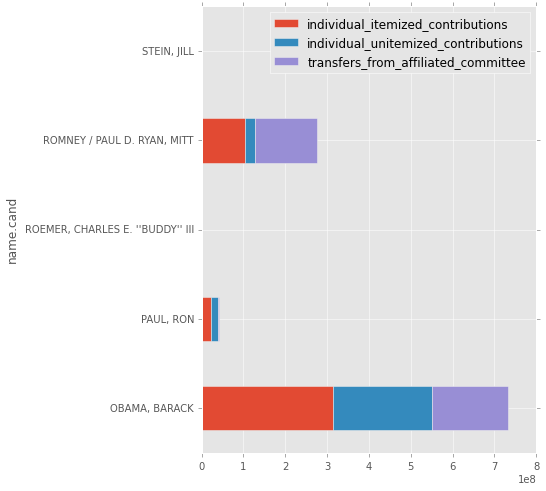

In [0]:
comparison.set_index('name.cand')[
    [
     'individual_itemized_contributions',
     'individual_unitemized_contributions',
     'transfers_from_affiliated_committee',
    ]
].plot(kind='barh', stacked=True, figsize=(6,8))

## The Whole Picture

Unfortunately, this is only the part of the picture when we are endeavoring to describe the campaign spending associated with a particular race.